In [2]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Create needed functions**

### **Function to create dataframe from dataset**

In [3]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

### **Function to create image generators and augmentation**

In [4]:
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255
        msk = msk / 255
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)

### **Function that have Unet structure**

In [6]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

### **Functions for coefficients and loss**

In [7]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

### **Function to show images sample**

In [8]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

# **Model Structure**

### **Start reading data**

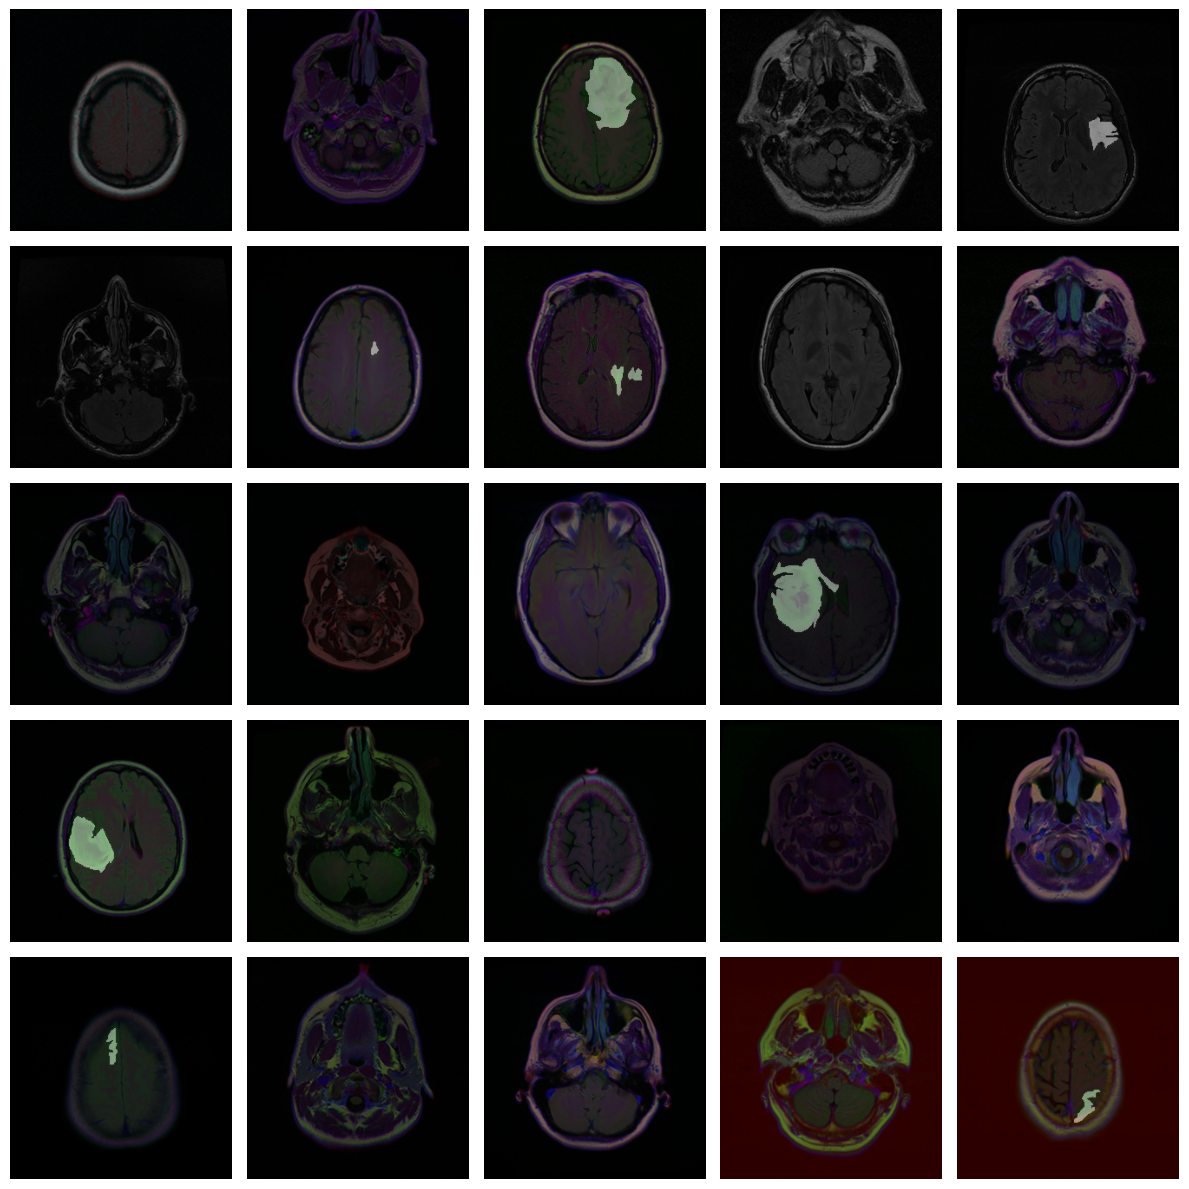

In [10]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)


tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [11]:
def visualize_ahe_images(df, aug_dict, num_images=5):
    # Call the generator function to get images and masks
    gen = create_gens_with_ahe(df, aug_dict)
    
    # Loop through the generated images and masks
    for img_batch, mask_batch in gen:
        for i in range(min(num_images, img_batch.shape[0])):  # Display a specified number of images
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            # Show the image
            ax[0].imshow(img_batch[i])
            ax[0].set_title('Image (After AHE)')
            ax[0].axis('off')
            
            # Show the corresponding mask
            ax[1].imshow(mask_batch[i].squeeze(), cmap='gray')
            ax[1].set_title('Mask')
            ax[1].axis('off')
            
            # Display the figure
            plt.tight_layout()
            plt.show()
        
        # Exit after showing the specified number of images
        num_images -= img_batch.shape[0]
        if num_images <= 0:
            break

In [12]:
def visualize_images(df, aug_dict, num_images=5):
    # Call the generator function to get images and masks
    gen = create_gens(df, aug_dict)
    
    # Loop through the generated images and masks
    for img_batch, mask_batch in gen:
        for i in range(min(num_images, img_batch.shape[0])):  # Display a specified number of images
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            # Show the image
            ax[0].imshow(img_batch[i])
            ax[0].set_title('Image (Without AHE)')
            ax[0].axis('off')
            
            # Show the corresponding mask
            ax[1].imshow(mask_batch[i].squeeze(), cmap='gray')
            ax[1].set_title('Mask')
            ax[1].axis('off')
            
            # Display the figure
            plt.tight_layout()
            plt.show()
        
        # Exit after showing the specified number of images
        num_images -= img_batch.shape[0]
        if num_images <= 0:
            break

### **Unet Model**

In [15]:
model = unet()
model2 = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

model2.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

### **Model training**

In [16]:
def create_gens_with_ahe1(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        for i in range(img.shape[0]):
            # Divide image into sub-images for AHE
            img_height, img_width, _ = img[i].shape
            N = 128  # Size of sub-images (128x128 is an example)

            # Iterate over the image in N x N patches
            for row in range(0, img_height, N):
                for col in range(0, img_width, N):
                    # Extract the sub-image
                    sub_img = img[i][row:row + N, col:col + N]
                    
                    # Convert sub-image to LAB color space
                    lab_img = cv2.cvtColor(sub_img, cv2.COLOR_RGB2LAB)
                    l, a, b = cv2.split(lab_img)

                    # Apply CLAHE to the L-channel of the sub-image
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    cl = clahe.apply(l)

                    # Merge the processed L-channel back with A and B channels
                    merged_sub_img = cv2.merge((cl, a, b))
                    # Convert back to RGB
                    rgb_sub_img = cv2.cvtColor(merged_sub_img, cv2.COLOR_LAB2RGB)

                    # Replace the original patch with the processed patch
                    img[i][row:row + N, col:col + N] = rgb_sub_img

        # Normalize image and mask
        img = img / 255.0
        msk = msk / 255.0

        # Binarize mask
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)
        
        
train_gen_model2 = create_gens_with_ahe1(train_df, aug_dict=tr_aug_dict)
valid_gen_model2 = create_gens_with_ahe1(valid_df, aug_dict={})
test_gen_model2 = create_gens_with_ahe1(test_df, aug_dict={})

In [17]:
epochs = 120
batch_size = 40
import math

callbacks2= ModelCheckpoint('unetlatest.weights.h5', verbose=0, save_best_only=True, save_weights_only=True)


In [18]:
# import math
# batch_size = 40
# epochs =  120
#callbacks2= [ModelCheckpoint('unet2.keras', verbose=0, save_best_only=True)]



# Helper functions to convert between RGB and HSI
def rgb_to_hsi(rgb_img):
    """Convert RGB image to HSI."""
    rgb_img = rgb_img / 255.0
    r, g, b = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]
    
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g) ** 2 + (r - b) * (g - b))
    theta = np.arccos(num / (den + 1e-6))  # Add small constant to avoid division by zero

    h = np.where(b <= g, theta, 2 * np.pi - theta)
    h = h / (2 * np.pi)  # Normalize to [0, 1]

    s = 1 - (3 / (r + g + b + 1e-6)) * np.minimum(np.minimum(r, g), b)  # Saturation
    i = (r + g + b) / 3.0  # Intensity

    return np.stack([h, s, i], axis=-1)

def hsi_to_rgb(hsi_img):
    """Convert HSI image back to RGB."""
    h, s, i = hsi_img[:, :, 0], hsi_img[:, :, 1], hsi_img[:, :, 2]

    h = h * 2 * np.pi  # Convert hue to radians
    r = np.zeros_like(h)
    g = np.zeros_like(h)
    b = np.zeros_like(h)

    # Calculate RGB from HSI
    idx1 = (0 <= h) & (h < 2 * np.pi / 3)
    r[idx1] = i[idx1] * (1 + s[idx1] * np.cos(h[idx1]) / (np.cos(np.pi / 3 - h[idx1]) + 1e-6))
    b[idx1] = i[idx1] * (1 - s[idx1])
    g[idx1] = 3 * i[idx1] - (r[idx1] + b[idx1])

    idx2 = (2 * np.pi / 3 <= h) & (h < 4 * np.pi / 3)
    h[idx2] = h[idx2] - 2 * np.pi / 3
    g[idx2] = i[idx2] * (1 + s[idx2] * np.cos(h[idx2]) / (np.cos(np.pi / 3 - h[idx2]) + 1e-6))
    r[idx2] = i[idx2] * (1 - s[idx2])
    b[idx2] = 3 * i[idx2] - (r[idx2] + g[idx2])

    idx3 = (4 * np.pi / 3 <= h) & (h < 2 * np.pi)
    h[idx3] = h[idx3] - 4 * np.pi / 3
    b[idx3] = i[idx3] * (1 + s[idx3] * np.cos(h[idx3]) / (np.cos(np.pi / 3 - h[idx3]) + 1e-6))
    g[idx3] = i[idx3] * (1 - s[idx3])
    r[idx3] = 3 * i[idx3] - (g[idx3] + b[idx3])

    rgb_img = np.stack([r, g, b], axis=-1)
    rgb_img = np.clip(rgb_img * 255.0, 0, 255).astype('uint8')

    return rgb_img



def create_gens_with_ahe(df, aug_dict):
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator
    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', target_size=img_size,
                                            batch_size=batch_size, save_to_dir=None, save_prefix='mask', seed=1)

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        for i in range(img.shape[0]):
            # Divide image into sub-images for AHE
            img_height, img_width, _ = img[i].shape
            N = 128  # Size of sub-images (128x128 is an example)

            # Iterate over the image in N x N patches
            for row in range(0, img_height, N):
                for col in range(0, img_width, N):
                    # Extract the sub-image
                    sub_img = img[i][row:row + N, col:col + N]
                    
                    # Convert sub-image to HSI color space
                    hsi_img = rgb_to_hsi(sub_img)
                    h, s, intensity = cv2.split(hsi_img)

                    # Convert intensity to uint8 before applying CLAHE
                    intensity_uint8 = (intensity * 255).astype('uint8')

                    # Apply CLAHE to the intensity channel
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    cl = clahe.apply(intensity_uint8)

                    # Normalize the intensity channel and merge back with H and S channels
                    cl_normalized = cl / 255.0
                    merged_sub_img = np.stack([h, s, cl_normalized], axis=-1)

                    # Convert back to RGB
                    rgb_sub_img = hsi_to_rgb(merged_sub_img)

                    # Replace the original patch with the processed patch
                    img[i][row:row + N, col:col + N] = rgb_sub_img


        # Normalize image and mask
        img = img / 255.0
        msk = msk / 255.0

        # Binarize mask
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)
        
train_gen_model2 = create_gens_with_ahe(train_df, aug_dict=tr_aug_dict)
valid_gen_model2 = create_gens_with_ahe(valid_df, aug_dict={})
test_gen_model2 = create_gens_with_ahe(test_df, aug_dict={})

In [19]:
history2 = model2.fit(train_gen_model2,
                    steps_per_epoch= math.ceil(len(train_df) / batch_size),
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks2,
                    validation_data = valid_gen_model2,
                    validation_steps=math.ceil(len(valid_df) / batch_size))


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120


I0000 00:00:1726978548.591886     393 service.cc:145] XLA service 0x79ebec03ba10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726978548.591949     393 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726978548.591957     393 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-09-22 04:16:51.124488: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[40,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[40,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-22 04:16:51.134745: E external/local_x

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9065 - dice_coef: 0.1461 - iou_coef: 0.0822 - loss: -0.1461Found 393 validated image filenames.
Found 393 validated image filenames.
79/79 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.9072 - dice_coef: 0.1471 - iou_coef: 0.0829 - loss: -0.1471 - val_accuracy: 0.2438 - val_dice_coef: 0.0292 - val_iou_coef: 0.0149 - val_loss: -0.0291
Epoch 2/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9924 - dice_coef: 0.4531 - iou_coef: 0.2975 - loss: -0.4531 - val_accuracy: 0.2782 - val_dice_coef: 0.0272 - val_iou_coef: 0.0138 - val_loss: -0.0273
Epoch 3/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9932 - dice_coef: 0.5836 - iou_coef: 0.4190 - loss: -0.5835 - val_accuracy: 0.8262 - val_dice_coef: 0.0990 - val_iou_coef: 0.0523 - val_loss: -0.0989
Epoch 4/120
79/79 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9946 - dice_coef: 0.6532 - iou_coef: 0.4920 - loss: -0.6532 - val_accuracy: 0.9459 - val_dice_coef: 0.2423 - val_

### **Model Evaluation**

In [20]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model2.evaluate(train_gen_model2, steps= test_steps, verbose= 1)
valid_score = model2.evaluate(valid_gen_model2, steps= test_steps, verbose= 1)
test_score = model2.evaluate(test_gen_model2, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
# print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
# print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
# print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9984 - dice_coef: 0.9141 - iou_coef: 0.8427 - loss: -0.9141
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 912ms/step - accuracy: 0.9977 - dice_coef: 0.8921 - iou_coef: 0.8063 - loss: -0.8919
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 121s 921ms/step - accuracy: 0.9977 - dice_coef: 0.9038 - iou_coef: 0.8255 - loss: -0.9038
Train Loss:  -0.9148828387260437
Train Accuracy:  0.9983807802200317
Train Dice:  0.9149446487426758
--------------------
Valid Loss:  -0.892054557800293
Valid Accuracy:  0.9976655840873718
Valid Dice:  0.8922425508499146
--------------------
Test Loss:  -0.9038469791412354
Test Accuracy:  0.9976814985275269
Test Dice:  0.9039391875267029


# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


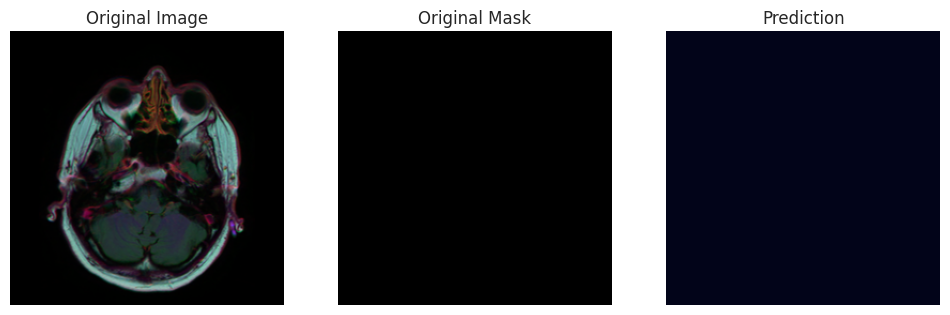

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


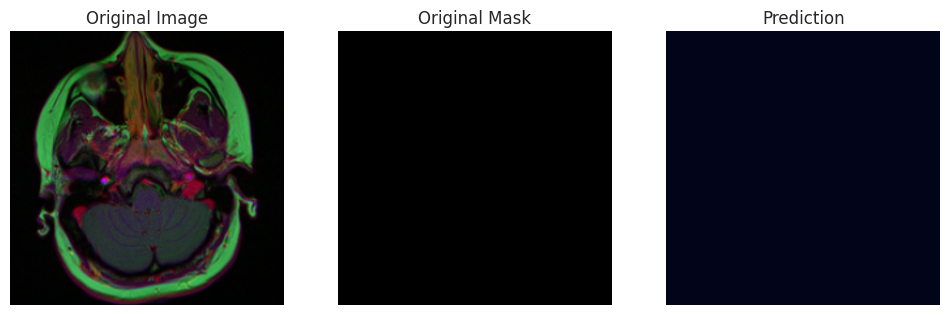

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


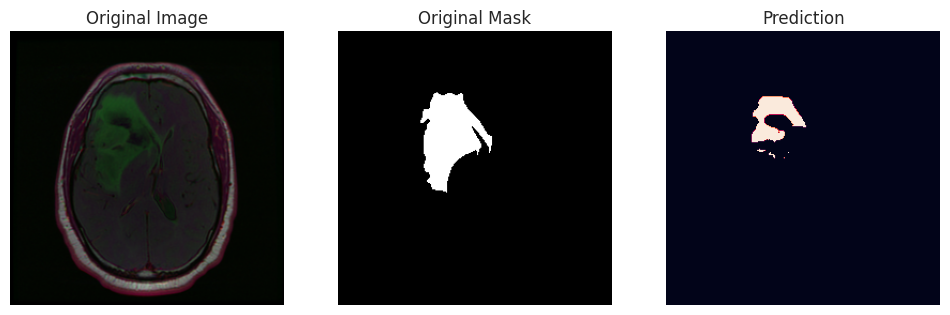

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


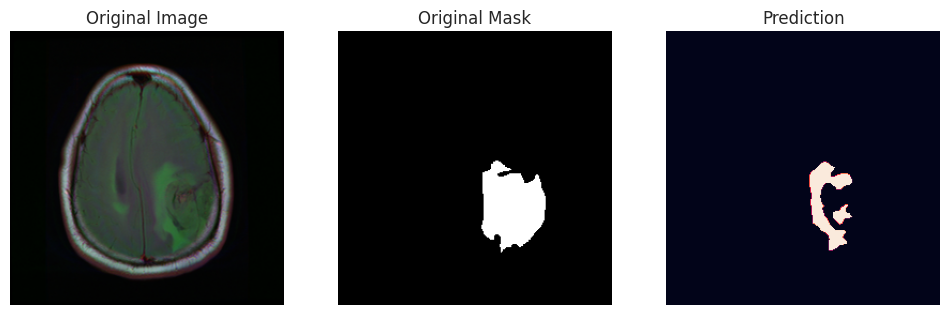

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


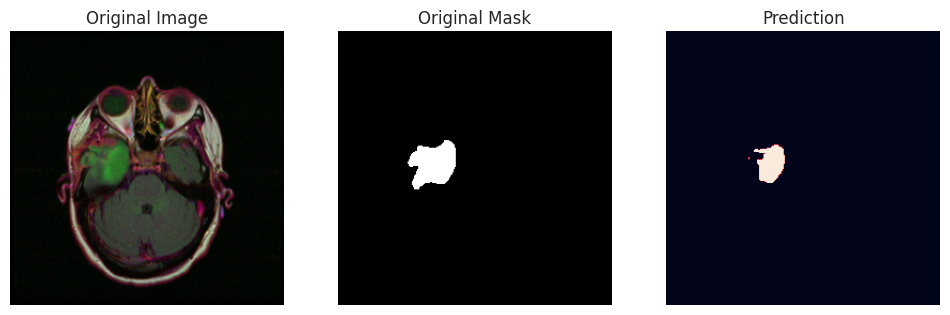

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


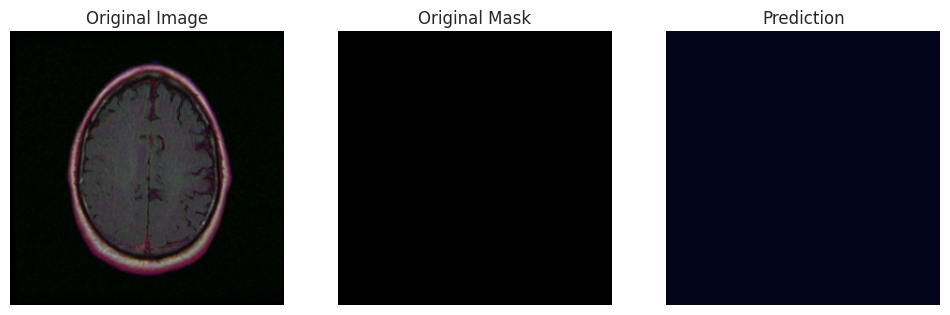

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


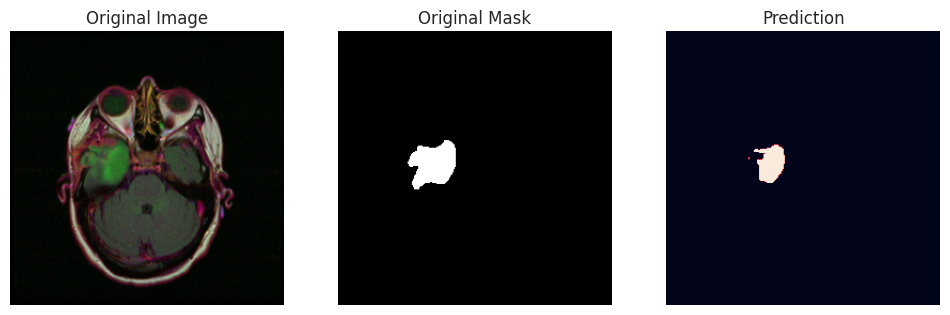

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


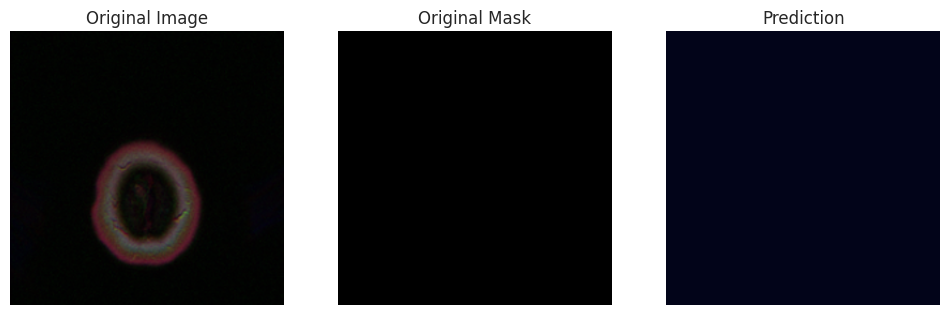

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


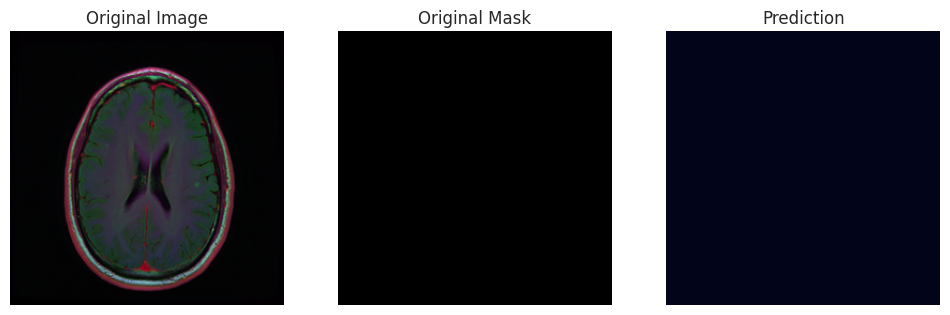

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


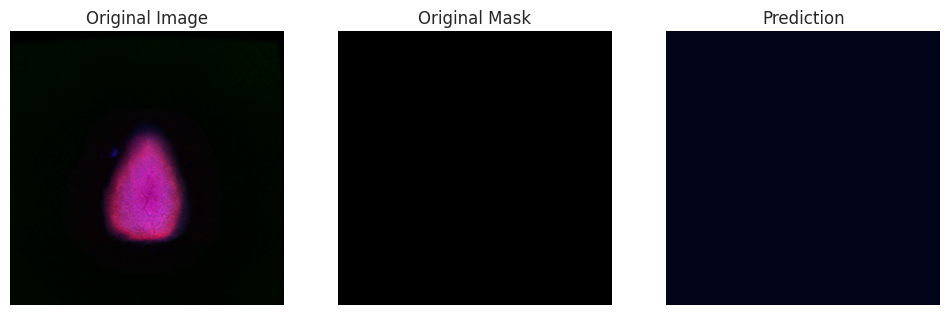

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


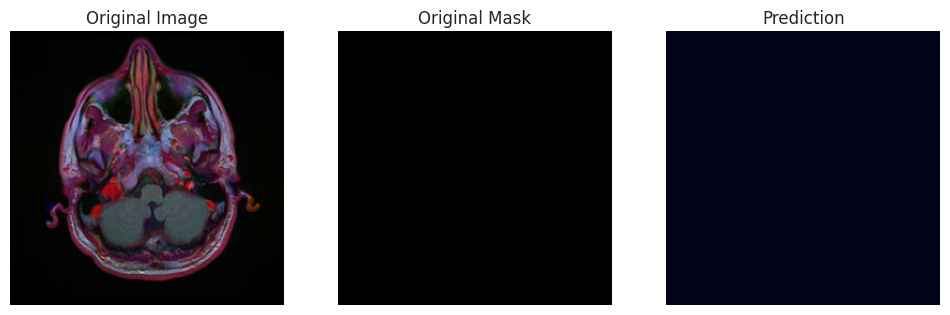

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


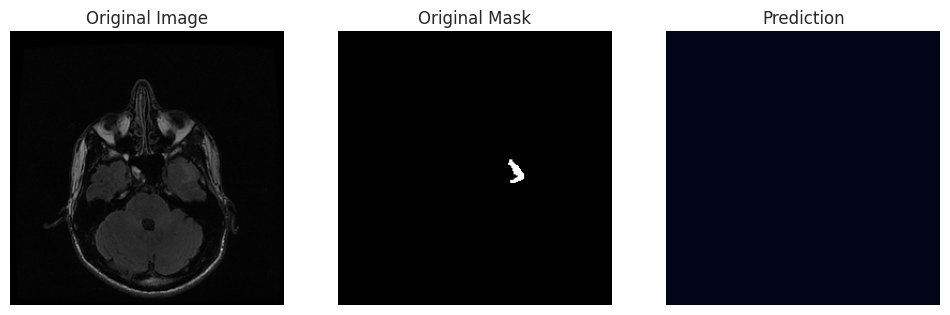

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


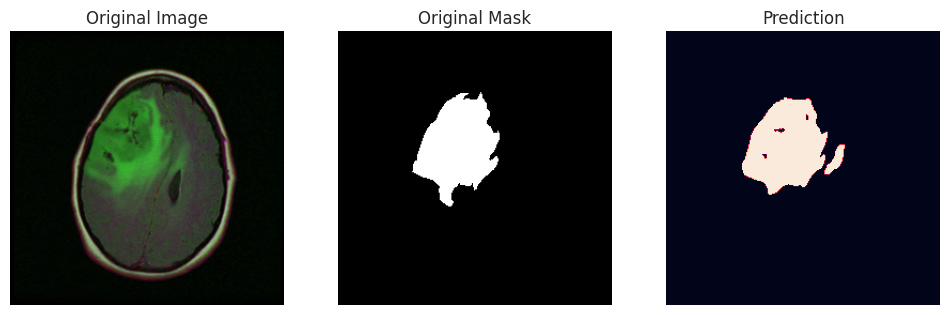

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


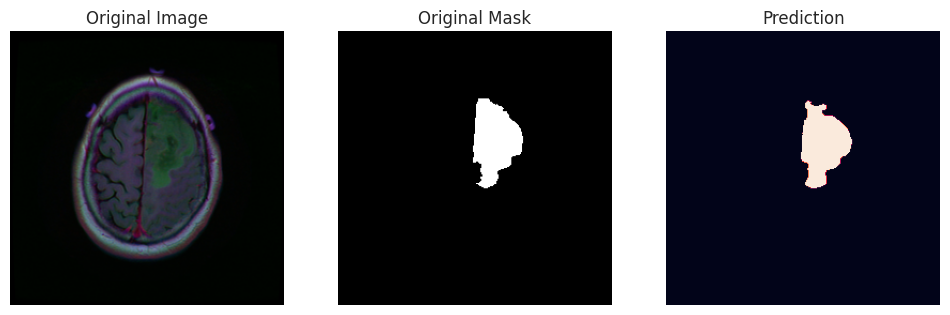

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


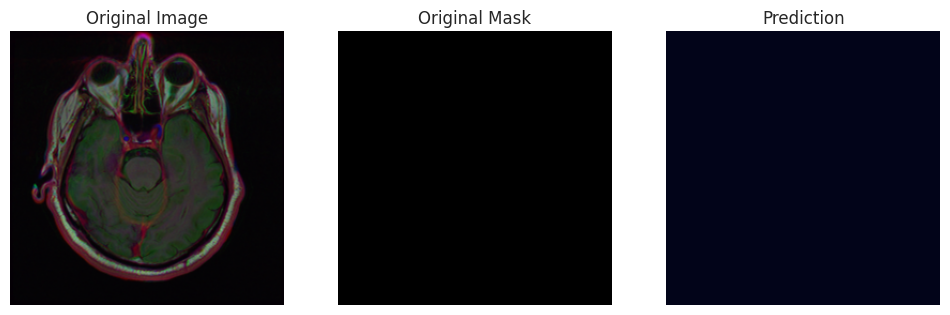

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


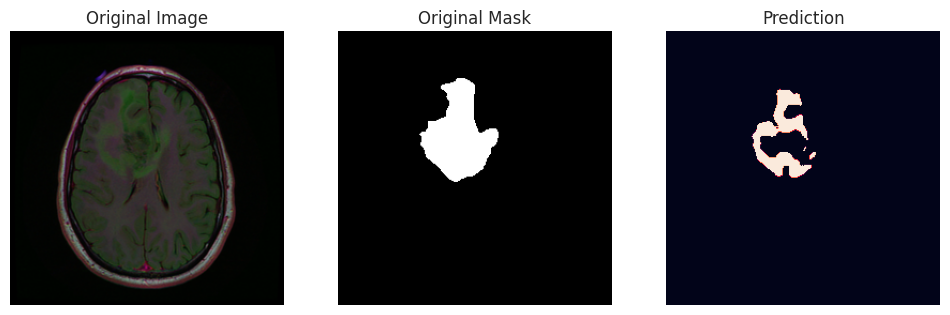

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


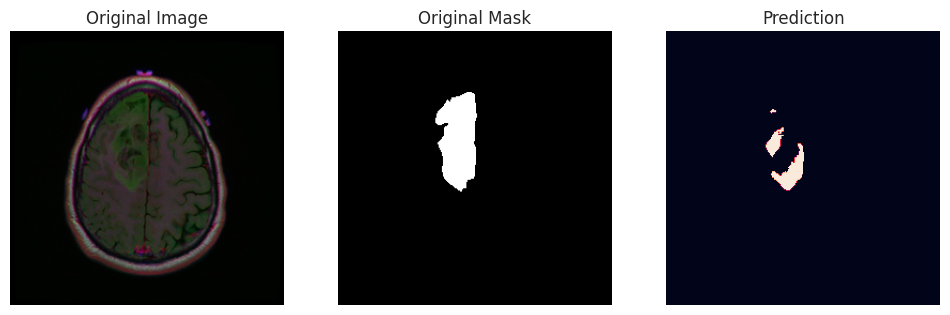

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


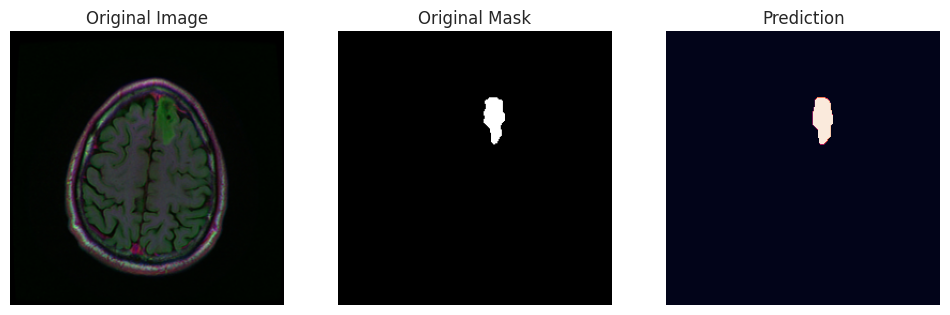

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


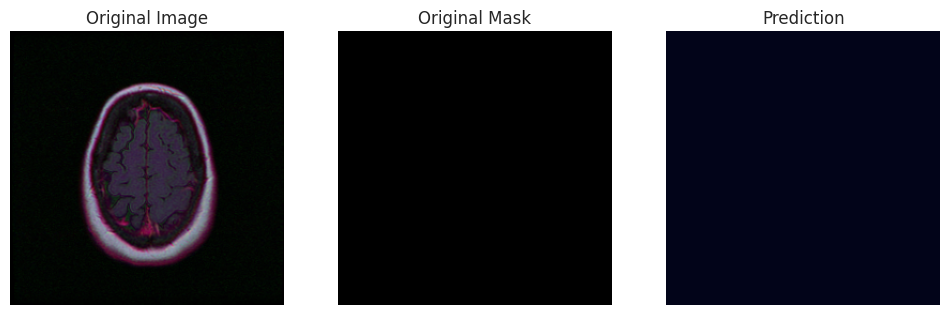

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


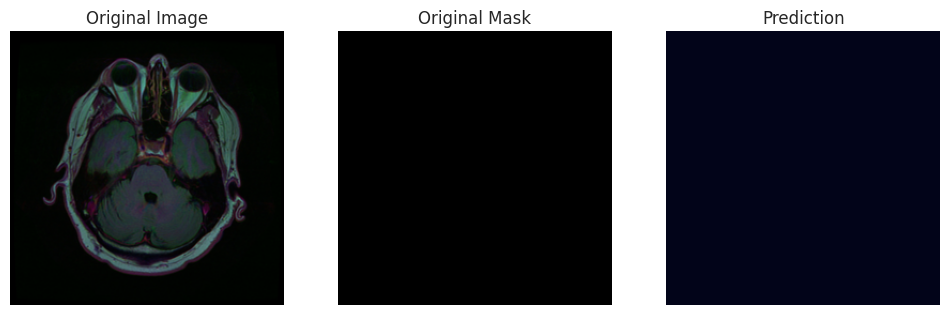

In [24]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model2.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()

In [29]:

from skimage.metrics import structural_similarity as ssim
import time


# Function to compute MSE
def mse(original_image, enhanced_image):
    """Calculate the Mean Squared Error between two images."""
    return np.mean((original_image - enhanced_image) ** 2)

# Function to compute PSNR
def psnr(original_image, enhanced_image):
    """Calculate the Peak Signal-to-Noise Ratio."""
    mse_value = mse(original_image, enhanced_image)
    if mse_value == 0:  # Avoid division by zero
        return float('inf')
    max_pixel = 255.0  # For 8-bit images
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE: 0.0
PSNR: inf


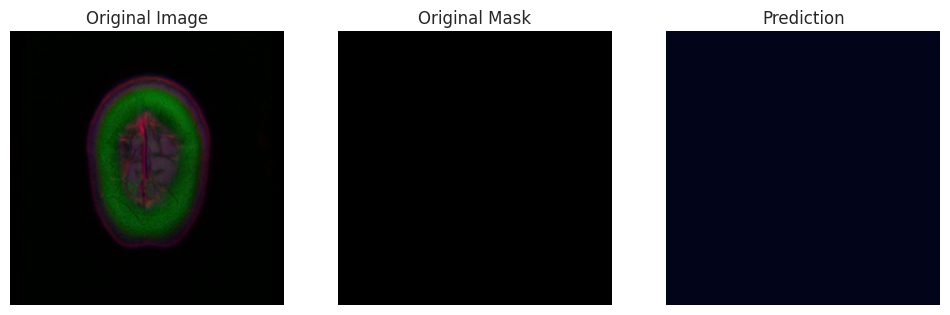

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.0
PSNR: inf


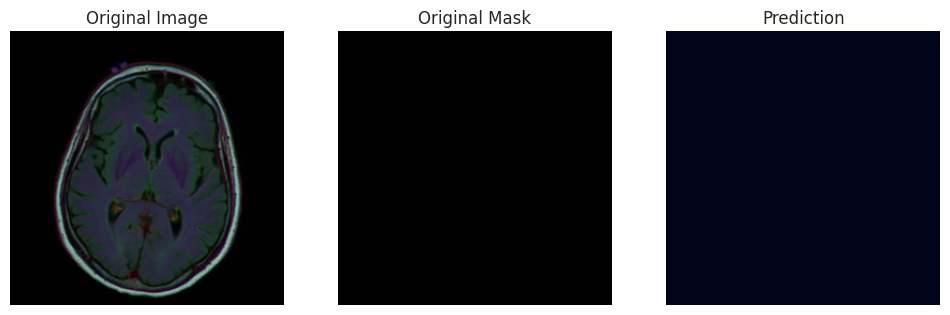

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.0236053466796875
PSNR: 64.40069977792243


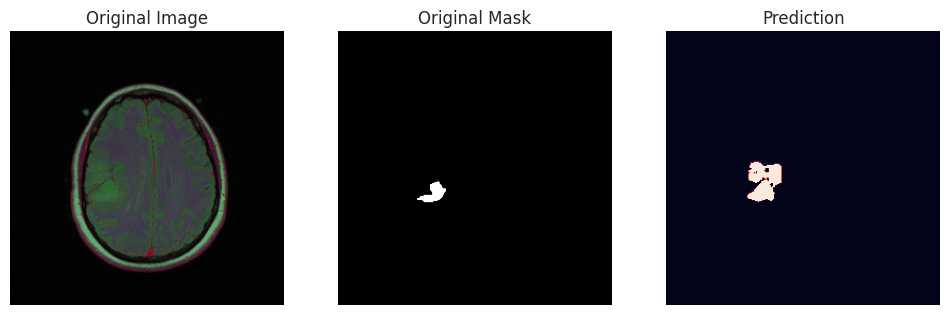

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE: 0.0
PSNR: inf


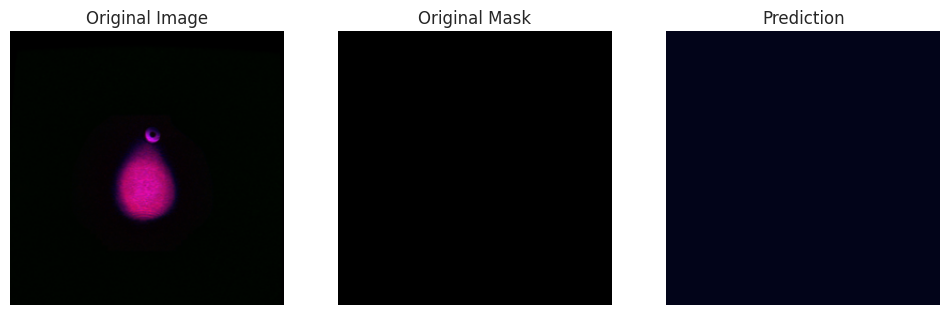

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE: 0.1073760986328125
PSNR: 57.82172740464213


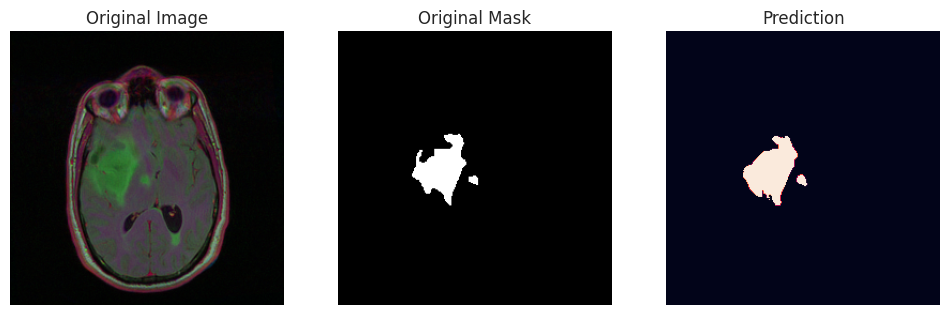

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE: 0.0182952880859375
PSNR: 65.50741108392761


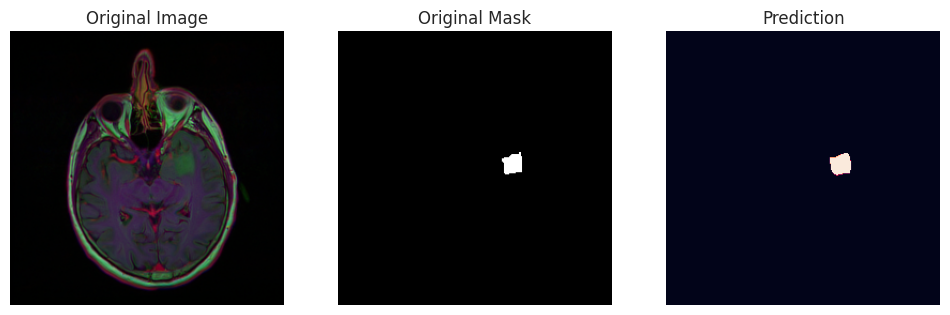

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE: 0.0377960205078125
PSNR: 62.356342849057725


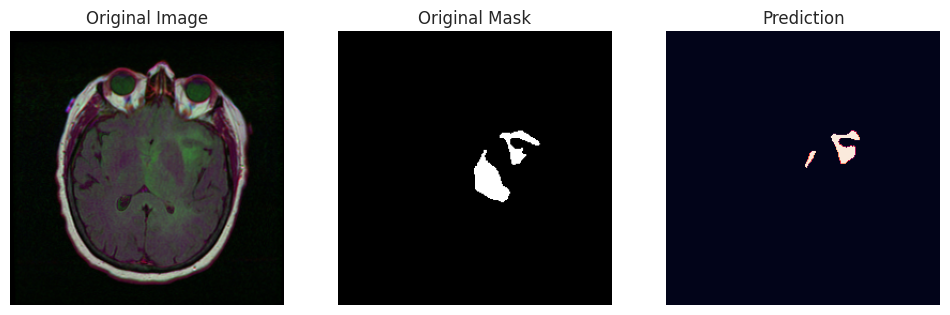

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.0
PSNR: inf


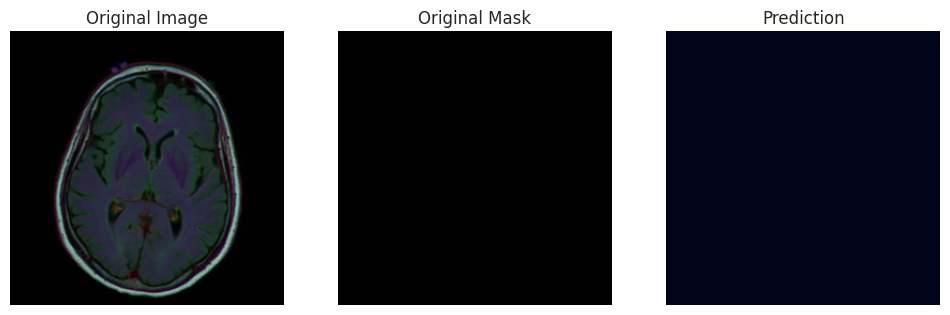

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.0
PSNR: inf


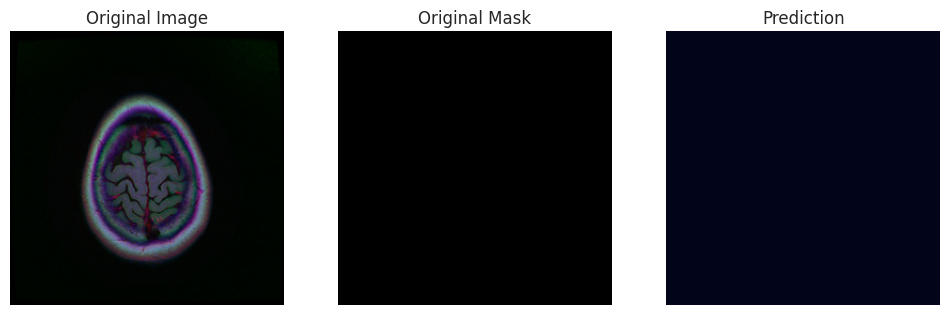

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MSE: 0.161590576171875
PSNR: 56.046643313841244


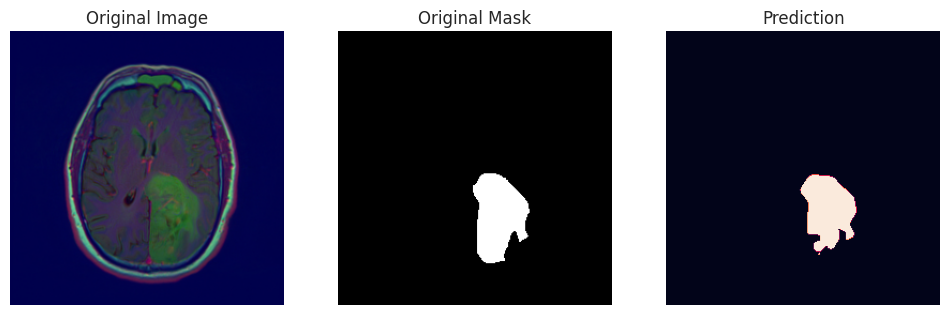

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE: 0.0
PSNR: inf


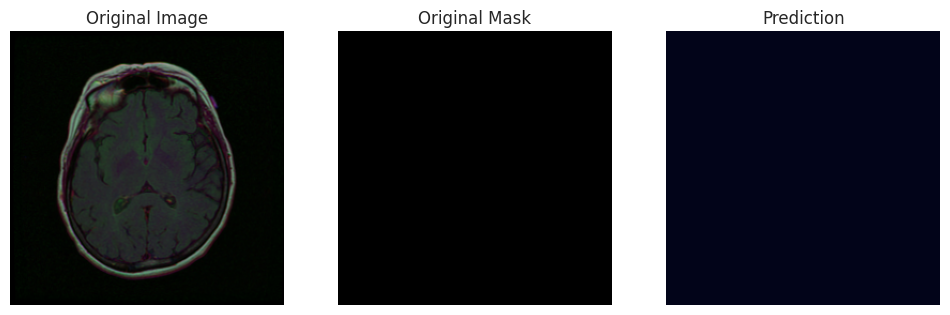

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE: 0.135833740234375
PSNR: 56.80072701545106


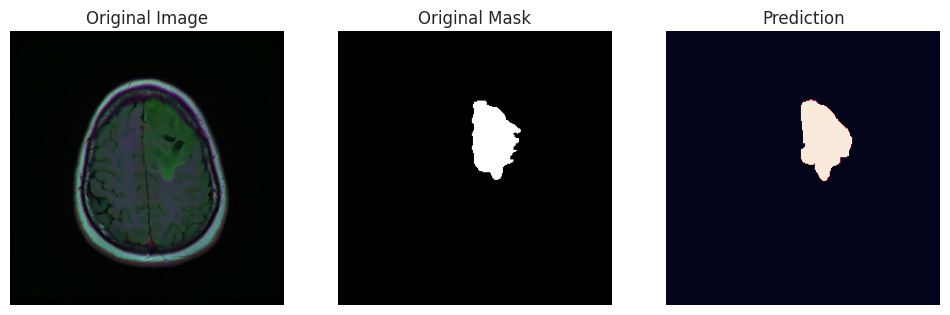

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.072998046875
PSNR: 59.49769120511255


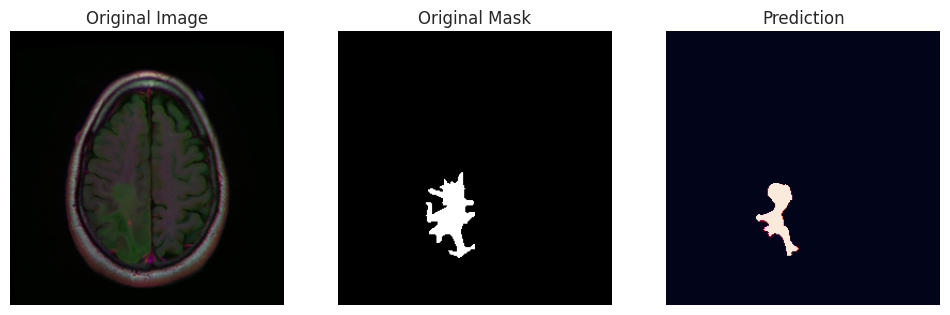

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MSE: 0.0
PSNR: inf


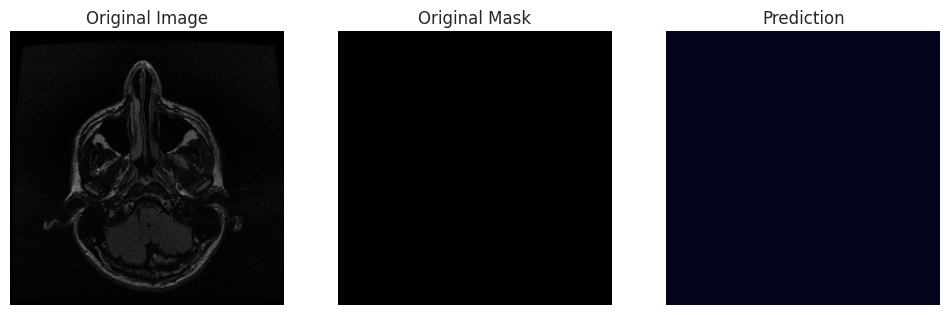

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.0
PSNR: inf


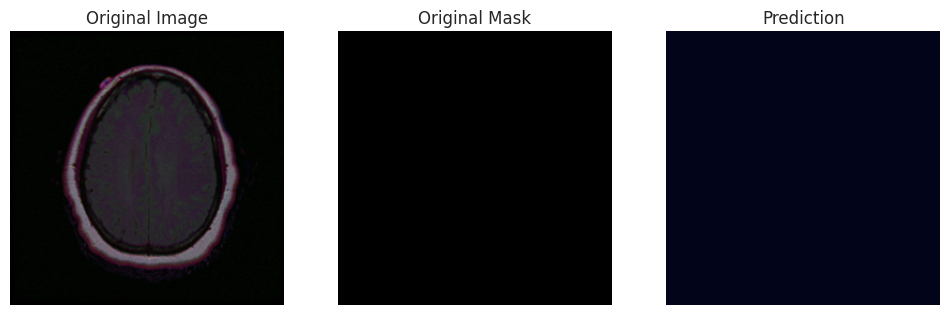

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.143310546875
PSNR: 56.568022075880705


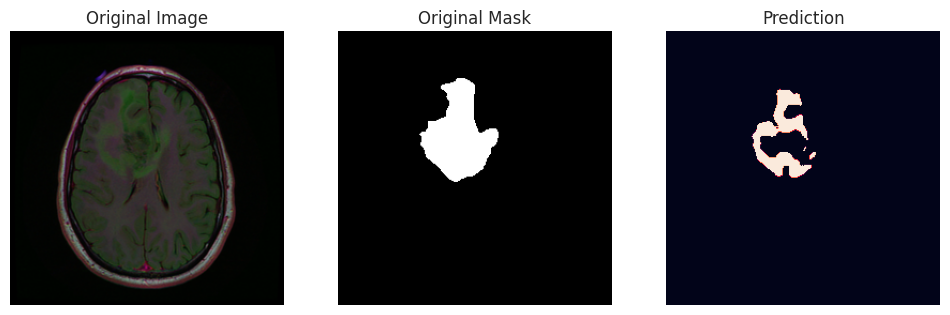

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.001617431640625
PSNR: 76.0425442622684


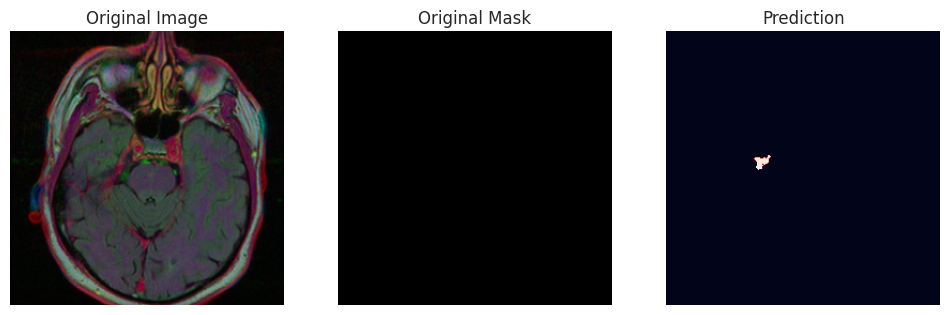

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.0
PSNR: inf


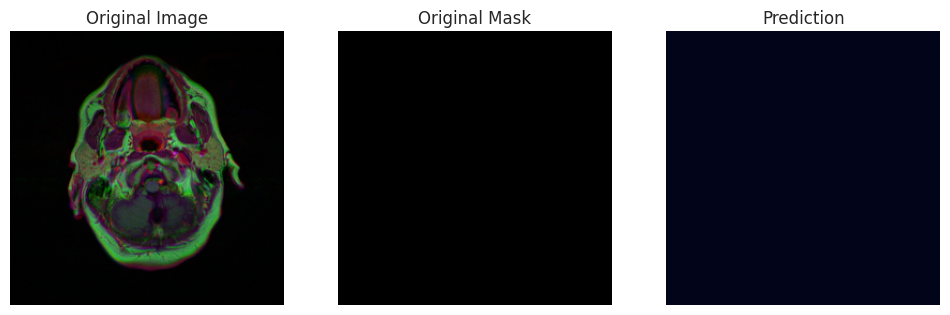

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE: 0.0145263671875
PSNR: 66.50923343107135


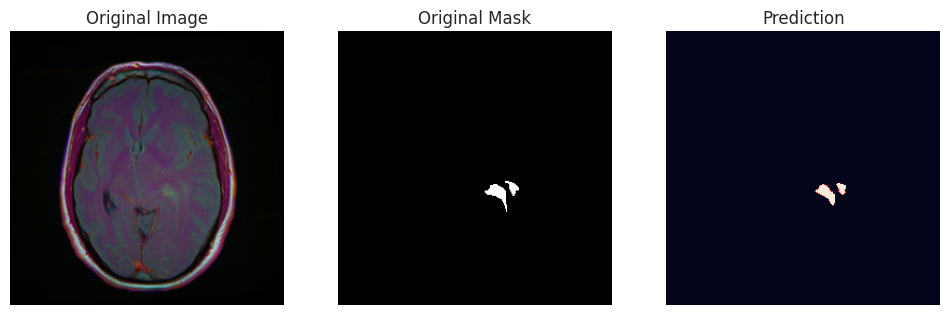

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.05413818359375
PSNR: 60.79576680331921


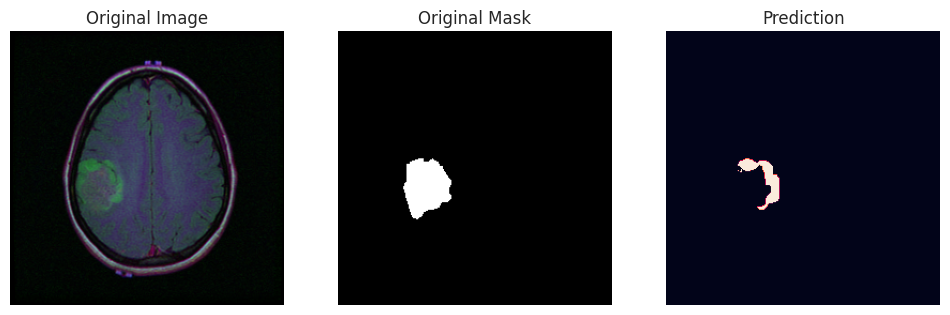

In [30]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model2.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    original_image = np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index]))
    enhanced_image = np.squeeze(predicted_img) > 0.5 
    
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Ensure enhanced_image is in the same format (e.g., binary mask)
    enhanced_image = enhanced_image.astype(np.uint8)  # Convert to uint8 type if needed
    
    mse_value = mse(original_image, enhanced_image)
    psnr_value = psnr(original_image, enhanced_image)
    
    print(f"MSE: {mse_value}")
    print(f"PSNR: {psnr_value}")
    
    plt.show()